<a href="https://colab.research.google.com/github/Swanimadhoop/computer-vision/blob/main/cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

implemnet a sift based image matching between 2 images and visualise the matched key points

In [2]:
!pip install opencv-contrib-python matplotlib


Total keypoints in Image 1: 604
Total keypoints in Image 2: 969
Good matches after ratio test: 80


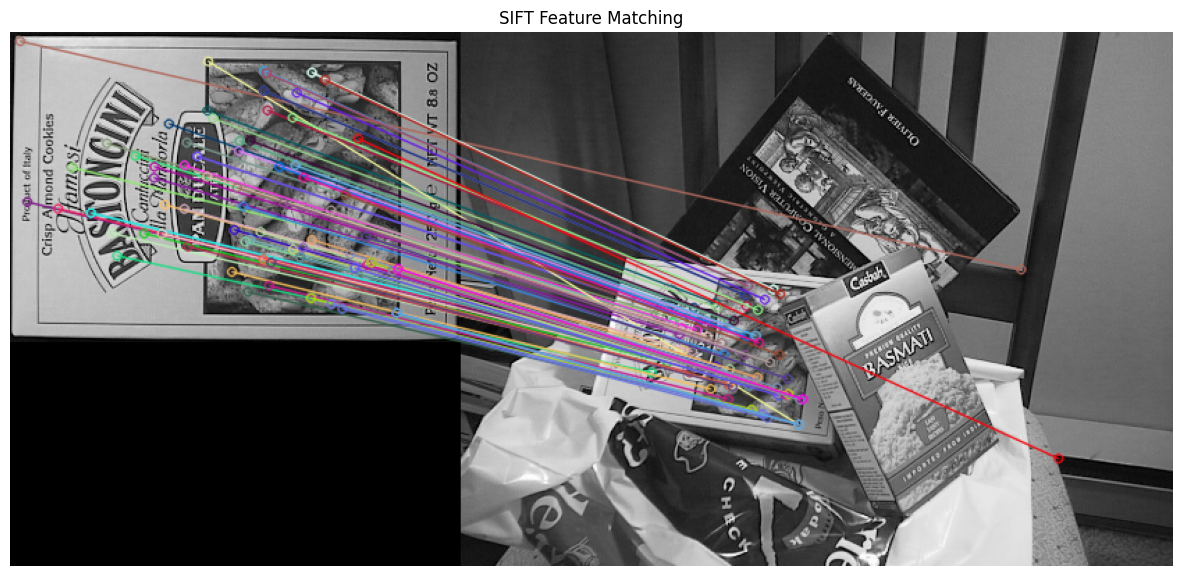

In [6]:
import cv2
import matplotlib.pyplot as plt


# 1. Load images (grayscale)
img1 = cv2.imread("box.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("box_in_scene.png", cv2.IMREAD_GRAYSCALE)

if img1 is None or img2 is None:
    raise ValueError("Could not load input images")

# -----------------------------
# 2. Create SIFT detector
# -----------------------------
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# -----------------------------
# 3. Feature matching (BFMatcher)
# -----------------------------
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

matches = bf.knnMatch(des1, des2, k=2)

# -----------------------------
# 4. Lowe's Ratio Test
# -----------------------------
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Total keypoints in Image 1: {len(kp1)}")
print(f"Total keypoints in Image 2: {len(kp2)}")
print(f"Good matches after ratio test: {len(good_matches)}")

# -----------------------------
# 5. Draw matches
# -----------------------------
matched_img = cv2.drawMatches(
    img1, kp1,
    img2, kp2,
    good_matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# -----------------------------
# 6. Visualize
# -----------------------------
plt.figure(figsize=(15, 8))
plt.imshow(matched_img, cmap='gray')
plt.title("SIFT Feature Matching")
plt.axis("off")
plt.show()


implement a pedestrian detection sysytem using HOG and SVM and evaluate the accuracy




In [ ]:
!pip install opencv-python opencv-contrib-python numpy matplotlib


In [24]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow


In [25]:
!wget -O PennFudanPed.zip https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!rm -rf PennFudanPed
!unzip -oq PennFudanPed.zip


--2026-01-30 05:50:20--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  61.7MB/s    in 0.8s    

2026-01-30 05:50:21 (61.7 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]



In [26]:
!ls PennFudanPed


added-object-list.txt  Annotation  PedMasks  PNGImages	readme.txt


In [27]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())


In [28]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    return interArea / (boxAArea + boxBArea - interArea + 1e-6)


In [35]:
import re

def load_ground_truth(txt_file):
    boxes = []
    with open(txt_file, "r") as f:
        for line in f:
            line = line.strip()

            if "Bounding box" in line:
                numbers = list(map(int, re.findall(r'\d+', line)))

                # Take LAST 4 numbers only
                xmin, ymin, xmax, ymax = numbers[-4:]

                w = xmax - xmin
                h = ymax - ymin

                boxes.append((xmin, ymin, w, h))

    return boxes


In [39]:
TP, FP, FN = 0, 0, 0

image_dir = "PennFudanPed/PNGImages"
anno_dir = "PennFudanPed/Annotation"

image_files = sorted(os.listdir(image_dir))

for img_name in image_files[:25]:   # limit for speed
    img_path = os.path.join(image_dir, img_name)
    txt_path = os.path.join(anno_dir, img_name.replace(".png", ".txt"))

    image = cv2.imread(img_path)
    gt_boxes = load_ground_truth(txt_path)

    detections, _ = hog.detectMultiScale(
        image,
        winStride=(4, 4),
        padding=(8, 8),
        scale=1.03
    )

    matched_gt = set()

    for det in detections:
        matched = False
        for i, gt in enumerate(gt_boxes):
            if compute_iou(det, gt) >= 0.5 and i not in matched_gt:
                TP += 1
                matched_gt.add(i)
                matched = True
                break
        if not matched:
            FP += 1

    FN += len(gt_boxes) - len(matched_gt)


In [40]:
precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("===== Evaluation Results =====")
print(f"True Positives : {TP}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"Precision      : {precision:.3f}")
print(f"Recall         : {recall:.3f}")
print(f"F1 Score       : {f1:.3f}")


===== Evaluation Results =====
True Positives : 24
False Positives: 26
False Negatives: 21
Precision      : 0.480
Recall         : 0.533
F1 Score       : 0.505


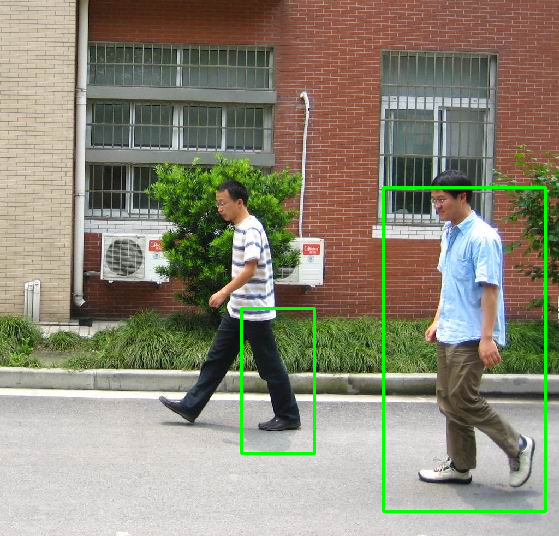

In [41]:
sample_image = cv2.imread(os.path.join(image_dir, image_files[0]))

detections, _ = hog.detectMultiScale(sample_image)

for (x, y, w, h) in detections:
    cv2.rectangle(sample_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

cv2_imshow(sample_image)
